## Set-up

In [2]:
import tensorflow as tf
from object_detection.utils import config_util
import os
from object_detection.builders import model_builder
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import array_to_img
from pathlib import Path

## Load Train Model From Checkpoint

In [3]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file("my_ssd_mobnet/pipeline.config")
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join('my_ssd_mobnet/', 'ckpt-5')).expect_partial()   # checkpoint 5 seems to be a better model

## Helper Functions for Prediction

In [4]:
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [5]:
def load_image_into_numpy_array(path):
    return np.array(Image.open(path))

In [6]:
def inference_with_bbox(path2images, box_th=0.4, path2dir=False):   
    # path2dir needs to be specified if path2images has only basenames
    res = []

    if path2dir:
        tmp = path2images.copy()
        for i in range(len(tmp)):
            full_path = os.path.join(path2dir, tmp[i].strip())
            path2images[i] = full_path
        
    for image_path in path2images:    # for each image, do shoe detection
        image_np = load_image_into_numpy_array(image_path)
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect_fn(input_tensor)
        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy()
                      for key, value in detections.items()}
        detections['num_detections'] = num_detections
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        boxes = []
        for i in range(len(detections['detection_boxes'])):
            if detections['detection_scores'][i] > box_th:
                boxes.append(detections['detection_boxes'][i])
        res.append(boxes)
        
    return res

In [7]:
def crop(path2images, save=False, show=False):
    all_boxes = inference_with_bbox(path2images, box_th=0.4)
    
    if save:
        if not os.path.exists(save):
            os.makedirs(save)
        
    for i in range(len(path2images)):
        if all_boxes[i] == []:    # no shoes detected
            continue
        
        image_np = load_image_into_numpy_array(path2images[i])

        for j in range(len(all_boxes[i])):    # loop through all boxes in a picture
            a, b, c, d = all_boxes[i][j]    # normalized coordinates of bounding box
            xmin = int(np.round(b * 320))
            xmax = int(np.round(d * 320))
            ymin = int(np.round(a * 240))
            ymax = int(np.round(c * 240))
            # (xmin,ymin) is the top left corner; (xmax,ymax) is the bottom right corner

            shoe = array_to_img(image_np[ymin:ymax+1, xmin:xmax+1])
            if save:
                shoe.save(f"{save}/{i+1}-{j+1}.jpg")
            if show:
                display(shoe)   # to check image is cropped properly

## Testing

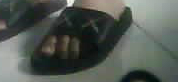

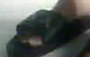

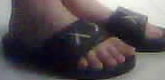

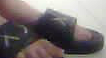

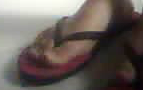

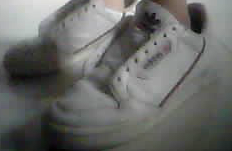

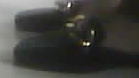

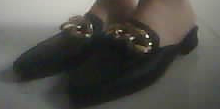

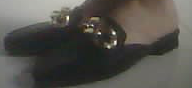

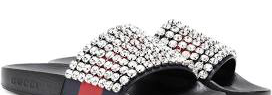

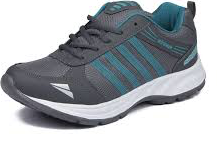

In [8]:
# paths = ['3-1.jpg', '1-1.jpg']
folder_dir = "test_images"
images = Path(folder_dir).glob('*')
paths = [str(i) for i in images]   

# crop(paths, show=True)    # display cropped pictures but doesn't save them into a folder
crop(paths, save="output/2022.10.23", show=True)    # save the cropped shoes into a folder called "output"
